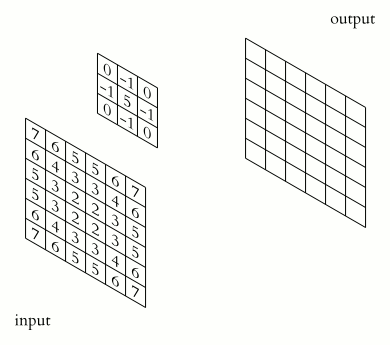

In [7]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display
from pathlib import Path

gifPath = Path("/Users/sasa/Workspace/Python/notes/file_ope/convolution.gif")

with open(gifPath,'rb') as f:
  display.Image(data=f.read(), format='png')

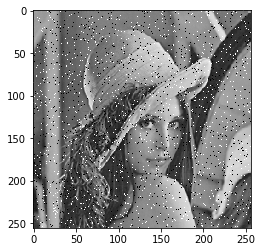

In [8]:
# OpenCVを使った方法(filter2d)

import numpy as np
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/Users/sasa/Workspace/Python/notes/file_ope/Lenna_gray_noise.png", 1)
plt.imshow(img)

In [9]:
kernel = np.full((3, 3), 1/9)
print(kernel)

[[0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]
 [0.11111111 0.11111111 0.11111111]]


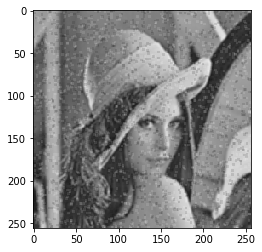

In [10]:
img2 = cv2.filter2D(img, -1, kernel)
plt.imshow(img2)

numpyで畳み込み演算(numpy.convolve)

https://deepage.net/features/numpy-convolve.html

In [11]:
ary = np.array([0, 1, 2, 3, 4, 5])
kernel = np.array([0.2, 0.8])
# kernelは各軸に対して反転された物がconvolutionされる

print(f"same mode: {np.convolve(ary, kernel, mode='same')}")
print(f"full mode: {np.convolve(ary, kernel, mode='full')}")
print(f"valid mode: {np.convolve(ary, kernel, mode='valid')}")

same mode: [0.  0.2 1.2 2.2 3.2 4.2]
full mode: [0.  0.2 1.2 2.2 3.2 4.2 4. ]
valid mode: [0.2 1.2 2.2 3.2 4.2]


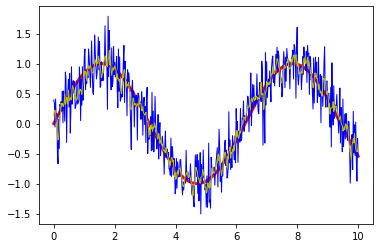

In [12]:
# 移動平均を使ってノイズの混じったデータを平滑化
x = np.linspace(0, 10, 500)
y1 = np.sin(x)
y2 = y1 + np.random.randn(500)*0.3 # randn: 正規分布

kernel = np.ones(5)/5.0
y3 = np.convolve(y2, kernel, mode='same')

plt.plot(x, y1, 'r', linewidth=3)
plt.plot(x, y2, 'b', linewidth=1)
plt.plot(x, y3, 'y', linewidth=1)
plt.show()